<a href="https://colab.research.google.com/github/magnolia2001/Forest_Estimation/blob/main/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
from google.colab import drive
import numpy as np
drive.mount ('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# the zipped data is uploaded in the root_path folder
root_path = 'drive/MyDrive/Colab Notebooks/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'
user = "lgiesen"
repo = "forest_height"
!git clone https://github.com/{user}/{repo}.git

Cloning into 'forest_height'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 232 (delta 48), reused 54 (delta 22), pack-reused 137
Receiving objects: 100% (232/232), 19.25 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (114/114), done.


解压工作目录下的四个压缩包（分别是['masks_train.zip', 'images_train.zip', 'masks_02.zip', 'images_02.zip']）,解压后的卫星图像和掩膜图像分别放置在路径path_images和路径path_masks下,并且这些文件都为.npy文件。后续加载X和y就是从此路径加载

%run 命令是在 Colab 笔记本中执行外部 Python 脚本的便捷方式。运行脚本中的代码会：
1.将所有print语句的输出显示在 Colab 单元格下方。并且将代码加载到 IPython 内核：
2.将脚本中的函数、类、变量等加载到 Colab 的 IPython 内核中，使它们在当前会话中可用。
3.不会直接插入代码到笔记本：脚本的代码不会被直接复制粘贴到你的笔记本文件中。


In [ ]:
%run /content/forest_height/src/generate_data.py

In [ ]:
from os import listdir
from os.path import isfile, join
from zipfile import ZipFile

import numpy as np
from sklearn.model_selection import train_test_split


# 使用generate_dataset_OriTotalData(path_images, path_masks)函数（这个函数使用到了定义的函数 get_files(dir, filetype=None)、extract_data_normalization(path_images, path_masks, filetype=None)和extract_labels_multi_channel(X, y) ）就可以生成可以直接输入到机器学习中的数据集
# 或者也可以使用generate_dataset(path_images, path_masks, is_balanced=False, scale_values=True, filetype=None)函数（这个函数使用到了定义的函数 get_files(dir, filetype=None)、extract_data(path_images, path_masks, filetype=None)、extract_labels(X, y)和 upsample_data(df) ）生成数据集，这个方式比前者更加灵活

# def get_files(dir):
#     """
#     Get all files from a directory

#     Parameters
#     ----------
#     dir: Array of strings

#     Returns
#     -------
#     Array of strings
#     """
#     return [f for f in listdir(dir) if isfile(join(dir, f))]


def get_files(dir, filetype=None):
    """
    Get all files from a directory

    Parameters
    ----------
    dir: Array of strings

    Returns
    -------
    Array of strings
      返回的是一个 字符串数组，即包含文件名的列表。
    """
    files = [f for f in listdir(dir) if isfile(join(dir, f))]
    if filetype:
        files = list(filter(lambda k: f'.{filetype}' in k, files))
    return files


def extract_data_normalization(path_images, path_masks, filetype=None):
    """
    Extract data from zipped files

    Parameters
    ----------
    path_images: String
    path_masks: String
    Path to the train data (default: None)
    root_path + filename = complete filepath

    Returns
    -------
    dataset: Tuple of np.ndarray
    """

    # load satellite images by loading the first one and then concatenating the rest
    # get_files(path_images, filetype) 得到一个卫星影像名的字符串数组
    X = np.load(f'{path_images}{get_files(path_images, filetype)[0]}')
    for filename in get_files(path_images, filetype)[1:]:
        temp = np.load(f'{path_images}{filename}', allow_pickle=True)
        X = np.concatenate((X, temp))
    # reshape X to distinguish between image and color channel
    # 重塑后的形状为：(num_imgs, color_channels, height, width)
    num_imgs = len(get_files(path_images))
    X = X.reshape((num_imgs, int(X.shape[0]/num_imgs), X.shape[1], X.shape[2]))
    #scale values between 0 and 1
    # 对于加载的数据的归一化：
    # 1.在拼接所有影像后，统计每个波段的最小值和最大值：
    # 2.采用如果数据量较大，可以在加载和拼接阶段统计最值，避免额外的内存开销
    # 由于我就一张拼接后的多波段影像，故我采用方式1
    # Calculate per-band statistics
    # 实现 按每个通道分别归一化 的效果
    # 计算每个通道的最小值和最大值
    X_min = X.min(axis=(0, 2, 3), keepdims=True)  # Keep channel dimension，形状为 (1, color_channels, 1, 1)，广播机制确保 X_min 和 X_max 被正确扩展到与 X 相同的形状。
    X_max = X.max(axis=(0, 2, 3), keepdims=True)  # 形状为 (1, color_channels, 1, 1)，广播机制确保 X_min 和 X_max 被正确扩展到与 X 相同的形状。
    # Normalize data based on per-band min and max
    X = (X - X_min) / (X_max - X_min)  # 归一化后的 X 的形状不变，仍然是 (num_imgs, color_channels, height, width)

    # load labels by loading the first one and then concatenating the rest
    y = np.load(f'{path_masks}{get_files(path_masks, filetype)[0]}')
    for filename in get_files(path_masks, filetype)[1:]:
        temp = np.load(f'{path_masks}{filename}', allow_pickle=True)
        y = np.concatenate((y, temp))

    del temp, num_imgs, X_min, X_max

    # 返回的X的形状为(num_imgs, color_channels, height, width)，
    # 返回的y的形状为(num_imgs, height, width)，由于y的通道数为1，所以通道数天然地可以看作图像数，但是这样在后续的某些处理中，y和X的后续处理会有些不同
    return (X, y)


# 此函数只可帮助实现所有波段功能参与数据集构建
def extract_labels_multi_channel(X, y):
    """
    Extract all channel values corresponding to non-zero labels.
    实现逐通道对齐，需要对索引进行扩展，确保每个非零标签位置在所有通道上都有对应的像素值

    Parameters
    ----------
    X: numpy.ndarray, shape = (num_imgs, color_channels, height, width)
    y: numpy.ndarray, shape = (num_imgs, height, width)

    Returns
    -------
    Tuple of numpy.ndarray
    """
    X_labeled_list = []  # 用于存储每张图像的提取结果

    for img_idx in range(y.shape[0]):
        # 获取标签非零索引
        nonzero_indices = np.nonzero(y[img_idx].flat)[0]
        # 提取所有通道对应的像素值
        color_channels, height, width = X[img_idx].shape[1:] # 提取通道和尺寸信息
        # 偏移量
        offset = height * width # 当前图像每个通道的偏移量
        # 为每个通道生成索引
        expanded_indices = np.concatenate([nonzero_indices + i * offset for i in range(color_channels)])
        # 提取出一张图像上非零标签值对应的所有通道的像素值
        corresponding_X_values = X[img_idx].flat[expanded_indices]
        corresponding_X_values = corresponding_X_values.reshape(-1, color_channels)

        # 提取非零标签值
        corresponding_y_values = y[img_idx].flat[nonzero_indices]

        # 添加到结果列表中
        X_labeled_list.append(corresponding_X_values)
        y_labeled_list.append(corresponding_y_values)

    # 拼接所有图像的结果
    X_labeled = np.concatenate(X_labeled_list, axis=0) # 形状为 (total_nonzero_labels, color_channels)
    y_labeled = np.concatenate(y_labeled_list, axis=0) # 形状为 (total_nonzero_labels,)

    # the length of X and y has to be the same
    # 验证形状一致性
    assert X_labeled.shape[0] == y_labeled.shape[0], "Mismatch in labeled data shape!"


    del corresponding_X_values, corresponding_y_values, nonzero_indices, expanded_indices
    return (X_labeled, y_labeled)


# 注意不要混淆在数据和在矩阵中的表示方式
# 在 数组（numpy.ndarray） 中，逗号表示换行（在二维及以上数组中），逻辑上对应于传统矩阵中的“换行”。
# 而不是像矩阵中那样换行才能表示新的一行。
# 这个generate_dataset函数可以生成直接输入到机器学习模型中的数据集。这个数据集是生成包含所有波段的数据的最庞大最完整的数据集，就是原始数据集，没经过上采样等操作
def generate_dataset_OriTotalData(path_images, path_masks):
    """
    Generate a dataset (X_train, X_test, y_train, y_test) based on the location of zip files

    Parameters
    ----------
    path_images: String
    path_masks: String

    Returns
    -------
    Numpy.ndarray
    """
    X, y = extract_data_normalization(path_images, path_masks, filetype)
    del path_images, path_masks
    X_labeled, y_labeled = extract_labels_multi_channel(X, y)
    del X, y
    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=0, shuffle=True)
    del X_labeled, y_labeled
    return (X_train, X_test, y_train, y_test)


def extract_data(path_images, path_masks, filetype=None):
    """
    Extract data from zipped files

    Parameters
    ----------
    path_images: String
    path_masks: String
    Path to the train data (default: None)
    root_path + filename = complete filepath

    Returns
    -------
    dataset: Tuple of np.ndarray
    """

    # load satellite images by loading the first one and then concatenating the rest
    # get_files(path_images, filetype) 得到一个卫星影像名的字符串数组
    X = np.load(f'{path_images}{get_files(path_images, filetype)[0]}')
    for filename in get_files(path_images, filetype)[1:]:
        temp = np.load(f'{path_images}{filename}', allow_pickle=True)
        X = np.concatenate((X, temp))
    # reshape X to distinguish between image and color channel
    # 重塑后的形状为：(num_imgs, color_channels, height, width)
    num_imgs = len(get_files(path_images))
    X = X.reshape((num_imgs, int(X.shape[0]/num_imgs), X.shape[1], X.shape[2]))

    # 定义的这个extract_data函数不进行归一化，但是在generate_dataset(path_images, path_masks, is_balanced=False, scale_values=True, filetype=None)函数需要默认scale_values=True以便进行标准化
    # extract_data函数与extract_data_normalization函数的区别就在于前者在加载数据阶段没有对数据进行0-1归一化保持数据值原始状态，而后者进行了0-1归一化
    # 之所以这么分，是因为可以灵活选择：
    # 1. 如果你的模型对输入数据的范围没有特别的敏感性，比如随机森林模型，它对特征的尺度不敏感，直接使用 0-1归一化 的数据是足够的，不需要再进行标准化
    # 2. 如果你使用的是对特征尺度敏感的模型，比如神经网络（CNN、NN等），标准化可能是有帮助的，因为神经网络通常在均值为 0、标准差为 1 的数据上表现更好（避免梯度消失或爆炸）

    # load labels by loading the first one and then concatenating the rest
    y = np.load(f'{path_masks}{get_files(path_masks, filetype)[0]}')
    for filename in get_files(path_masks, filetype)[1:]:
        temp = np.load(f'{path_masks}{filename}', allow_pickle=True)
        y = np.concatenate((y, temp))

    del temp, num_imgs, X_min, X_max

    # 返回的X的形状为(num_imgs, color_channels, height, width)，
    # 返回的y的形状为(num_imgs, height, width)，由于y的通道数为1，所以通道数天然地可以看作图像数，但是这样在后续的某些处理中，y和X的后续处理会有些不同
    return (X, y)

# 此函数可帮助实现可选波段功能参与数据集构建
# 提取多通道遥感影像数据 (X) 和其对应的标签数据 (y) 中标签非零的像素值，
# 并将它们以表格（pandas.DataFrame）的形式返回
def extract_labels(X, y):
    """
    Labels are sparse, so they are Get all labels (non-zero elements) from a set of images
    形象化来说，这个函数是否实现比如一张特征影像（即单个通道的数据）与其对应掩膜影像数据的生成

    Parameters
    ----------
    X: numpy.ndarray，
       多通道遥感影像数据，形状为 `(num_channels, height, width)`。
    y: numpy.ndarray
       对应的标签数据，形状为 `(height, width)`。

    Returns
    -------
    Tuple of numpy.ndarray
       包含多通道影像数据和非零标签值的 `pandas.DataFrame`。
       其中每一行是一个像素，包含它在各个波段的值（即多通道影像的值）（这里和extract_labels_multi_channel返回的X_labeled形状对应）和对应的非零标签。
    """
    # extract non-zero value indices from y (= label position) to extract the corresponding X-value
    # prepare data to merge it into one data frame,
    # which makes it easier to extract the values of the same pixel
    ## 注意，"当从 X[0].flat 中提取时，这些索引（y[0].flat中非零元素的索引）是否会作用于所有通道的数据，确保所有通道的像素值都被正确提取"这一点还不确定,目前我的想法是作者直接用标签的单通道索引从影像展平数组中提取值，这只会提取第一个通道的数据，后面的断言也只验证了单通道值的提取。
    ## X[0].flat 中的展平顺序保证了通道数据按照顺序排列（即需要确保 X 的结构是 (color_channels, height, width)，因为这样的话展平顺序就是展平每个通道上的所有像素，实现每个通道的展平后都是height*width个像素，这样就实现了空间位置的对齐）。
    # 这里的10应该是通道数，根据实际情况填写
    X = X.reshape(90, -1) # 将 X 转换为二维数组，形状变为 (90, height * width)。每一行表示一个通道的展平数据。
    y = y.reshape(1, -1)  # 将 y 转换为二维数组，形状变为 (1, height * width)
    # 将 X 和 y 在第 0 维（通道维度）上拼接.
    # 拼接后的 Xy 形状是 (91, height * width)，其中前 90 行是影像数据的各通道值，第 91 行是标签数据。
    Xy = np.concatenate((X, y), axis=0)
    # 对数据矩阵进行转置：Xy 的形状从 (91, height * width) 转变为 (height * width, 91)。
    # 每一行对应一个像素，包含其 90 个波段的影像值和标签值。这样方便后续按像素为单位操作。
    Xy = Xy.transpose()
    # 初始化空数组并拼接数据
    data = np.empty((0,91)) # 创建了一个没有元素的二维数组，其列数为 91
    data = np.concatenate((data, Xy), axis=0) # 用 np.concatenate 将 Xy 的数据拼接到 data 中.拼接后，data 的形状与 Xy 相同，仍为 (height * width, 91)

    # 提取非零标签对应的行
    # 提取非零标签的像素索引
    # data[:,-1] 提取 data 的最后一列（即标签数据）。
    # data[:,-1]是一个 一维数组，其形状为 (height * width,)，不是 (height * width, 1)
    # np.nonzero(data[:,-1]) 返回标签值不为零的像素索引。
    indices = np.nonzero(data[:,-1])
    # 根据索引提取对应的完整行，提取后的 labeled_data 形状为 (num_nonzero_labels, 91)
    labeled_data = data[indices]

    # create data frame with features and labels
    # 这个columns的名字和波段合成的顺序有关，那你写的波段名的意义需要与实际波段数据一一对应
    df = pd.DataFrame(
        labeled_data,
        columns = [
            'HHDivideByHV', 'RFDI', 'RVI', 'sigma_db_HH', 'sigma_db_HV', 'Entropy', 'Anisotropy', 'Alpha',
            'alpha_angle_degrees', 'delta', 'ro', 'spandB', 'mpdb', 'mvdb', 'mpdb-mvdb', 'mp', 'mv',
            'HH_Dir1_Mean', 'HH_Dir1_Variance', 'HH_Dir1_Homogeneity', 'HH_Dir1_Contrast', 'HH_Dir1_Dissimilarity', 'HH_Dir1_Entropy', 'HH_Dir1_Second Moment', 'HH_Dir1_Correlation',
            'HH_Dir2_Mean', 'HH_Dir2_Variance', 'HH_Dir2_Homogeneity', 'HH_Dir2_Contrast', 'HH_Dir2_Dissimilarity', 'HH_Dir2_Entropy', 'HH_Dir2_Second Moment', 'HH_Dir2_Correlation',
            'HH_Dir3_Mean', 'HH_Dir3_Variance', 'HH_Dir3_Homogeneity', 'HH_Dir3_Contrast', 'HH_Dir3_Dissimilarity', 'HH_Dir3_Entropy', 'HH_Dir3_Second Moment', 'HH_Dir3_Correlation',
            'HH_Dir4_Mean', 'HH_Dir4_Variance', 'HH_Dir4_Homogeneity', 'HH_Dir4_Contrast', 'HH_Dir4_Dissimilarity', 'HH_Dir4_Entropy', 'HH_Dir4_Second Moment', 'HH_Dir4_Correlation',
            'HV_Dir1_Mean', 'HV_Dir1_Variance', 'HV_Dir1_Homogeneity', 'HV_Dir1_Contrast', 'HV_Dir1_Dissimilarity', 'HV_Dir1_Entropy', 'HV_Dir1_Second Moment', 'HV_Dir1_Correlation',
            'HV_Dir2_Mean', 'HV_Dir2_Variance', 'HV_Dir2_Homogeneity', 'HV_Dir2_Contrast', 'HV_Dir2_Dissimilarity', 'HV_Dir2_Entropy', 'HV_Dir2_Second Moment', 'HV_Dir2_Correlation',
            'HV_Dir3_Mean', 'HV_Dir3_Variance', 'HV_Dir3_Homogeneity', 'HV_Dir3_Contrast', 'HV_Dir3_Dissimilarity', 'HV_Dir3_Entropy', 'HV_Dir3_Second Moment', 'HV_Dir3_Correlation',
            'HV_Dir4_Mean', 'HV_Dir4_Variance', 'HV_Dir4_Homogeneity', 'HV_Dir4_Contrast', 'HV_Dir4_Dissimilarity', 'HV_Dir4_Entropy', 'HV_Dir4_Second Moment', 'HV_Dir4_Correlation',
            'CosAspect', 'SinAspect', 'Aspect', 'M', 'Height', 'RLD5', 'Slope', 'SOA', 'SOS', 'Label'
        ]
    )

    return df




# 对数据集中的森林高度（标签值 Label）数据进行上采样，即增加低频类别（高度较低）的样本数量，以解决类别不平衡问题。
def upsample_data(df):
    """
    Upsample underrepresented data

    Parameters
    ----------
    df: pandas.DataFrame
      包含多个特征列和一个标签列 Label的 Pandas 数据框
      extract_labels(X, y)的函数返回值即满足要求

    Returns
    -------
    pandas.DataFrame
      返回一个经过上采样处理的数据框
    """

    # sort data according to tree height asc
    # df.sort_values('Label') 将输入数据框 df 按照标签列 Label 的值从小到大排序。不会修改原始数据框，而是返回一个新的数据框。新数据框仍然保留了原始的索引，但顺序与排序后的数据一致。故需要重置索引，丢弃旧索引，生成连续的新索引
    # reset_index(drop=True) 重置索引，丢弃旧索引，生成连续的新索引。将数据框的索引替换为从 0 开始的连续整数序列。默认情况下，原索引会作为一列保留。如果设置 drop=True，旧索引将被丢弃，不会保留为新列。
    dfs = df.sort_values('Label').reset_index(drop=True)
    # create empty data frame to fill
    # 初始化一个空的数据框 dff，列名与输入数据框 df 相同，用于存放经过上采样的数据。
    dff = pd.DataFrame(columns=df.columns)

    # 遍历区间并上采样
    index_start = 0
    # i为高度区间的上端点数据，即i为3，6，9，...，33，36
    # (i-3, i)就表示区间
    # 将标签值按区间 0-3, 3-6, ..., 33-36 划分，每次增加 3，共计 12 个区间。
    for i in range(3, 37, 3):
        #count the number of instances that are in one interval for example 0 - 3 or 15 - 18
        # dfs["Label"] > i - 3 和 dfs["Label"] < i 是布尔表达式，分别检查 dfs["Label"] 中的每个值是否满足条件。
        # 逐位（element-wise）的逻辑 与 操作符，用于将两个布尔 Series 按位结合，返回的是一个 Pandas 布尔 Series，形状与 dfs["Label"] 相同。
        # 使用布尔索引过滤 dfs["Label"] 中满足条件的值。返回一个 Pandas Series，只包含满足 (dfs["Label"] > i - 3) & (dfs["Label"] < i) 条件的值，其索引与原数据框保持一致。
        # .count() 方法用于统计满足条件 (dfs["Label"] > i - 3) & (dfs["Label"] < i) 的数据个数，返回一个整数，表示满足条件的数据个数。。
        index_end = index_start + dfs["Label"][(dfs["Label"] > i - 3) & (dfs["Label"] < i)].count()
        # take random sample of the interval
        # 从当前区间内的样本中，随机抽取 800 个样本。区间左闭右开。
        # 注意：若某区间的样本数小于 800，会报错（除非样本数量足够）
        samp = dfs[index_start:index_end].sample(800)
        # 将当前区间的采样结果拼接到上采样后的数据框 dff 中。
        dff = pd.concat((dff, samp))
        # 更新区间起点：
        index_start = index_end

    # add the highest values because there are only a few
    # 在最后一个区间（Label 值大于等于 36）之外，可能还有少量的样本，直接将这些样本添加到 dff，不再进行随机采样。
    dff = pd.concat((dff, dfs[index_start:]))
    #shuffle the dataset randomly
    # 随机打乱数据
    # dff.sample(frac=1)：打乱数据框中的所有行（frac=1 表示全部数据）
    # 重置索引，并丢弃旧索引。
    # 返回经过上采样和随机打乱的数据框 dff。
    return dff.sample(frac=1).reset_index(drop=True)


def generate_dataset(path_images, path_masks, output_variables=None, is_balanced=False, scale_values=True, filetype=None):
    """
    Generate a dataset (X_train, X_test, y_train, y_test) based on the location of zip files

    Parameters
    ----------
    path_images: String, 表示影像的路径
    path_masks: String, 表示掩膜文件的路径
    output_variables: List or None。
      如果为 None，生成完整数据集。如果为列表，只提取指定特征（列名列表）。例如：['HHDivideByHV', 'RFDI', 'RVI', 'sigma_db_HH', 'sigma_db_HV', 'Entropy', 'Anisotropy', 'Alpha', 'alpha_angle_degrees', 'delta', 'ro', 'spandB', 'mpdb', 'mvdb', 'mpdb-mvdb', 'HH_Dir2_Mean', 'HH_Dir2_Variance', 'HH_Dir2_Homogeneity', 'HH_Dir2_Contrast', 'HH_Dir2_Dissimilarity', 'HH_Dir2_Entropy', 'HH_Dir2_Second Moment', 'HH_Dir2_Correlation', 'Height', 'Aspect', 'Slope'])。
    is_balanced: 布尔值，默认值为 False。指定是否需要对数据进行平衡处理（例如，少数类的上采样）
    scale_values: 布尔值，默认值为 True。是否对特征值进行标准化（归一化到标准正态分布）。
    filetype: 文件类型，默认值为 None。可以指定数据文件的类型（如 .tif、.csv 等）。

    Returns
    -------
    pd.DataFrame
    一个包含两个 pandas.DataFrame 和两个 pandas.Series 的元组。
    每个元组的元素类型如下：
    - X_train: pandas.DataFrame, shape = (num_samples_train, num_features)
    - X_test: pandas.DataFrame, shape = (num_samples_test, num_features)
    - y_train: pandas.Series, shape = (num_samples_train,)
    - y_test: pandas.Series, shape = (num_samples_test,)
    """

    # 提取数据
    X, y = extract_data(path_images, path_masks, filetype)
    Xy = extract_labels(X, y)
    del X, y

    # 如果 is_balanced=True，调用 upsample_data 对数据进行类别平衡（例如对低森林高度的样本进行上采样）。
    if is_balanced:
        Xy = upsample_data(Xy)

    # 提取特征和标签
    # features = Xy.iloc[:, :-1]  # 提取所有列，除去最后一列
    # labels = Xy.iloc[:, -1]  # 最后一列是标签

    # Extract features and Labels
    # 从数据框 Xy 中提取前 90 列作为特征（影像的多通道数据）。（iloc[:, 0:90] 表示按列索引选择第 0 列到第 89 列，包含第 0 列和第 89 列）。
    # 提取出来的 features 仍然是一个 pandas.DataFrame，它保留了原始数据的列名。DataFrame 是二维表格结构，包含行和列。它的每列表示一个特征，每行表示一个样本。
    features = Xy.iloc[:, 0:90]  # 提取前 90 列作为特征
    # 从数据框 Xy 中提取第 91 列作为标签（掩膜中的森林高度值）。（iloc[:, 90] 表示按列索引选择第 91 列）
    # labels 类型是 pandas.Serie。labels 是一维数组结构，通常表示一个特定的字段或一列数据。在这里，labels 是目标值的集合，长度等于 features 的行数。且pandas.Series 中是没有列名的，因为 Series 是一维的，它只表示一个字段（列）或者一个数组。
    # 通常来说 labels 之所以是 pandas.Series，是因为它只有一列。如果 labels 包含多列数据，那么它会变成一个 pandas.DataFrame。
    # 具体来说 如果 labels 只有一列，用 iloc 或 df['Label'] 提取时，返回的就是 Series。如果 labels 有多列，或即使只有一列但用 iloc[:, 10:11] 提取，返回的就是 DataFrame。
    labels = Xy.iloc[:,90]  # 提取第 91 列作为标签
    del Xy

    # 如果指定了 output_variables，则只保留对应的特征列
    if output_variables is not None:
        # 使用列名来选取指定的列，返回的仍然是一个 DataFrame。
        features = features[output_variables]  # 提取指定的列

    # 特征值标准化
    if scale_values:
        # 标准化特征数据
        scaler = StandardScaler()
        # features 是通过 scaler.fit_transform(features) 从 pandas.DataFrame 类型转换成了 numpy.ndarray 类型
        scaled_features = scaler.fit_transform(features)  # 此时 scaled_features 是 numpy.ndarray 类型

        # 将标准化后的 numpy.ndarray 转换回 pandas.DataFrame，并保留原始的列名
        features = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

    # 划分训练集和测试集
    # X_train 和 X_test 是训练和测试集的特征，形状为 (num_samples, num_features)。
    # y_train 和 y_test 是训练和测试集的标签，形状为 (num_samples,)
    # 这个形状和generate_dataset_OriTotalData(path_images, path_masks)中生成的形状对应上了，说明这两者应该没有问题
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0, shuffle=True)
    del features, labels

    # (X_train, X_test, y_train, y_test) 是一个 元组 (tuple)，其中包含四个元素：X_train、X_test、y_train 和 y_test。
    # X_train 和 X_test 是 numpy.ndarray 类型，形状为 (num_samples, num_features)。
    # y_train 和 y_test 是 pandas.Series 类型，形状为 (num_samples,)。
    # train_test_split 默认不会改变 labels 的类型，因此 y_train 和 y_test 依然是 pandas.Series。
    return (X_train, X_test, y_train, y_test)


# 在调用save_dataset这个函数之前，需要先进入到需要保存的路径之下，然后调用，则可以将数据集保存到该路径之下
# 将生成的训练和测试数据集保存为 .pkl 格式，便于后续加载和使用。
def save_dataset(X_train, X_test, y_train, y_test):
    """
    Save the dataset to .pkl files
    """
    # 使用 pandas 的 to_pickle 方法保存 DataFrame 和 Series，保存后的数据与原始数据类型一致
    # 加载训练和测试数据
    X_train.to_pickle("X_train.pkl")
    y_train.to_pickle("y_train.pkl")
    X_test.to_pickle("X_test.pkl")
    y_test.to_pickle("y_test.pkl")


# 代码首先需要实现在forest_height/data/下创建子目录，专门用于实现存放训练集和测试集数据。
def load_data(data_type):
    """
    加载forest_height/data/下的训练集和测试集数据

    Parameters
    ----------
    data_type:字符串类型
      子目录名称

    Returns
    -------
    4 个 NumPy 数组
    """
    forest_data = "forest_height/data/"

    # 添加目录检查逻辑
    data_path = os.path.join(forest_data, data_type)

    # 检查目录是否存在
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"The directory '{data_path}' does not exist.")

    # 检查必要文件是否存在
    required_files = ["X_train.pkl", "y_train.pkl", "X_test.pkl", "y_test.pkl"]
    for file in required_files:
        if not os.path.exists(os.path.join(data_path, file)):
            raise FileNotFoundError(f"Missing required file '{file}' in '{data_path}'.")

    # 加载数据
    X_train = np.array(pd.read_pickle(f"{forest_data}{data_type}/X_train.pkl"))
    y_train = np.array(pd.read_pickle(f"{forest_data}{data_type}/y_train.pkl"))
    X_test = np.array(pd.read_pickle(f"{forest_data}{data_type}/X_test.pkl"))
    y_test = np.array(pd.read_pickle(f"{forest_data}{data_type}/y_test.pkl"))

    return (X_train, y_train, X_test, y_test)


import joblib
import matplotlib.pyplot as plt
from forest_height.src.load_data import load_data
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import (mean_absolute_error,mean_absolute_percentage_error,mean_squared_error)

color = "#01748F"


# 评估给定的机器学习模型在测试数据上的性能。
def evaluate_accuracy(model, test_features, test_labels):
    """
    Evaluate a model on specified datasets

    Parameters
    ----------
    model: sklearn.ensemble.*
      一个已经训练好的模型实例（如 RandomForestRegressor() 的实例）。必须是支持 .predict() 方法的对象。
    test_features: numpy.ndarray
      测试集特征（X_test），通常是一个二维数组或矩阵。
    test_labels: numpy.ndarray
      测试集标签（y_test），通常是一个一维数组或向量，表示每个样本的真实值。

    Returns
    -------
    # 准确率
    返回 (errors, mape, accuracy) 元组
    tuple
      包括 (errors, mape, accuracy)：
      - errors: 每个样本的绝对误差（numpy.ndarray）。长度等于测试集样本数量。用于分析模型在单个样本上的误差表现。
      - mape: 平均绝对百分比误差（float）。用于衡量模型在整体上的预测误差比例。
      - accuracy: 模型准确率（float）。表示模型的准确度，取决于 MAPE。
    """
    # 模型预测
    predictions = model.predict(test_features)

    # 计算预测值与真实标签之间的绝对误差。
    errors = abs(predictions - test_labels)

    # 计算MAPE（平均绝对百分比误差），MAPE 表示模型的预测误差占真实值的百分比。
    # 将结果乘以 100，将 MAPE 转换为百分比表示。
    mape = 100 * np.mean(errors / test_labels)

    # 计算准确率
    # 如果 MAPE 越小，说明模型的误差越小，那么准确率 accuracy 越高。
    accuracy = 100 - mape

    print('Model Performance')
    # 计算所有样本的平均绝对误差，作为模型在测试集上的总体误差。
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('MAPE: {:0.2f}%'.format(mape))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    # return accuracy
    # 返回误差、MAPE 和准确率
    return errors, mape, accuracy



def evaluate_RMSE(model, test_features, test_labels):
    """
    Evaluate a model on specified datasets

    Parameters
    ----------
    model: sklearn.ensemble.*
      一个已经训练好的模型实例（如 RandomForestRegressor() 的实例）。必须是支持 .predict() 方法的对象。
    test_features: numpy.ndarray
      测试集特征（X_test），通常是一个二维数组或矩阵。
    test_labels: numpy.ndarray
      测试集标签（y_test），通常是一个一维数组或向量，表示每个样本的真实值。

    Returns
    -------
    Errors (Tuple of Float)
    返回一个包含 4 个误差指标的元组（Tuple[float, float, float, float]）。
    分别是 MAE：平均绝对误差、 MSE：均方误差、 RMSE：均方根误差、 MAPE：平均绝对百分比误差
    """
    # 模型预测
    predictions = model.predict(test_features)

    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    rmse = mse ** (1/2)
    mape = mean_absolute_percentage_error(test_labels, predictions)
    print(f'MAE: {mae}; MSE: {mse}; RMSE: {rmse}; MAPE: {mape}')

    return (mae, mse, rmse, mape)



# 评估模型预测的性能。它接受真实值和预测值作为输入，计算并返回多个误差指标（MAE、MSE、RMSE、MAPE）。
def evaluate_model(y_test, y_pred):
    """
    Evaluates a model based on its test set prediction

    Parameters
    ----------
    输入变量可以接受 pandas.Series 或 numpy.array，只要输入变量形状相匹配即可
    （pandas.DataFrame也可以，如果传入的是 pandas.DataFrame，需要确保 DataFrame 是一维的，即只有一列（等价于 Series））

    Returns
    -------
    Errors (Tuple of Float)
    返回一个包含 4 个误差指标的元组（Tuple[float, float, float, float]）。
    分别是 MAE：平均绝对误差、 MSE：均方误差、 RMSE：均方根误差、 MAPE：平均绝对百分比误差
    """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'MAE: {mae}; MSE: {mse}; RMSE: {rmse}; MAPE: {mape}')

    return (mae, mse, rmse, mape)


# 注意这个函数时传入未进行训练的模型，所以调用这个函数的时候要注意这一点。我觉得在初始化模型后在未对模型进行训练之前，可以调用这个函数，因为在这个函数中还能评估模型性能。
def train_evaluate_model(model, dataset=["subset", "all"]):
    """
    Train and evaluate a model on specified datasets

    Parameters
    ----------
    model: sklearn.ensemble.*
      未训练的模型实例（如 RandomForestRegressor() 的实例）。必须是支持 .fit() 和 .predict() 方法的对象。
    dataset: Array of Strings
      数据集名称的列表，用于指定多个数据集。

    Returns
    -------
    None, just prints out errors of each dataset
    """
    # 遍历数据集
    for ds in dataset:
        # 输出当前数据集名称，方便跟踪训练和评估进度。
        print(f"Dataset: {ds}")
        # 加载数据，返回训练集和测试集
        X_train, y_train, X_test, y_test = load_data(ds)
        # train model
        model.fit(X_train, y_train)
        # predict test set
        y_pred = model.predict(X_test)
        # evaluate model
        mae, mse, rmse, mape = evaluate_model(y_test, y_pred)

        # 打印性能指标
        print(f"MAE: {mae:.5f}, MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAPE: {mape:.5f}\n")



# 为了适应不同的数据集，cols 应该动态调整，确保其与数据集的特征对应。
def feature_importance(
    model,
    model_name,
    columns = [
            'HHDivideByHV', 'RFDI', 'RVI', 'sigma_db_HH', 'sigma_db_HV', 'Entropy', 'Anisotropy', 'Alpha',
            'alpha_angle_degrees', 'delta', 'ro', 'spandB', 'mpdb', 'mvdb', 'mpdb-mvdb', 'mp', 'mv',
            'HH_Dir1_Mean', 'HH_Dir1_Variance', 'HH_Dir1_Homogeneity', 'HH_Dir1_Contrast', 'HH_Dir1_Dissimilarity', 'HH_Dir1_Entropy', 'HH_Dir1_Second Moment', 'HH_Dir1_Correlation',
            'HH_Dir2_Mean', 'HH_Dir2_Variance', 'HH_Dir2_Homogeneity', 'HH_Dir2_Contrast', 'HH_Dir2_Dissimilarity', 'HH_Dir2_Entropy', 'HH_Dir2_Second Moment', 'HH_Dir2_Correlation',
            'HH_Dir3_Mean', 'HH_Dir3_Variance', 'HH_Dir3_Homogeneity', 'HH_Dir3_Contrast', 'HH_Dir3_Dissimilarity', 'HH_Dir3_Entropy', 'HH_Dir3_Second Moment', 'HH_Dir3_Correlation',
            'HH_Dir4_Mean', 'HH_Dir4_Variance', 'HH_Dir4_Homogeneity', 'HH_Dir4_Contrast', 'HH_Dir4_Dissimilarity', 'HH_Dir4_Entropy', 'HH_Dir4_Second Moment', 'HH_Dir4_Correlation',
            'HV_Dir1_Mean', 'HV_Dir1_Variance', 'HV_Dir1_Homogeneity', 'HV_Dir1_Contrast', 'HV_Dir1_Dissimilarity', 'HV_Dir1_Entropy', 'HV_Dir1_Second Moment', 'HV_Dir1_Correlation',
            'HV_Dir2_Mean', 'HV_Dir2_Variance', 'HV_Dir2_Homogeneity', 'HV_Dir2_Contrast', 'HV_Dir2_Dissimilarity', 'HV_Dir2_Entropy', 'HV_Dir2_Second Moment', 'HV_Dir2_Correlation',
            'HV_Dir3_Mean', 'HV_Dir3_Variance', 'HV_Dir3_Homogeneity', 'HV_Dir3_Contrast', 'HV_Dir3_Dissimilarity', 'HV_Dir3_Entropy', 'HV_Dir3_Second Moment', 'HV_Dir3_Correlation',
            'HV_Dir4_Mean', 'HV_Dir4_Variance', 'HV_Dir4_Homogeneity', 'HV_Dir4_Contrast', 'HV_Dir4_Dissimilarity', 'HV_Dir4_Entropy', 'HV_Dir4_Second Moment', 'HV_Dir4_Correlation',
            'CosAspect', 'SinAspect', 'Aspect', 'M', 'Height', 'RLD5', 'Slope', 'SOA', 'SOS', 'Label'
        ]
    ):
    """
    Visualize feature importance of regression model

    Parameters
    ----------
    model: sklearn.ensemble.*
      一个已经训练好的回归模型，必须具有 feature_importances_ 属性。
    model_name: String
      模型的名称，用于可视化标题中显示。
    cols: Array of Strings
      list（字符串数组）.特征名称列表，用于匹配模型中的特征顺序。如果为 None，则自动生成 ["Feature 1", "Feature 2", ...]。

    Returns
    -------
    None, just prints out feature importances and plots them in a bar graph
      直接打印和绘制特征重要性。
    """
    # 这是一个数组，存储模型中每个特征的重要性分数。
    # importance = model.feature_importances_ 这个数组的长度与为喂给model进行训练模型的数据集中的特征数量一致，即importance 的长度等于训练数据集中特征的数量。
    importance = model.feature_importances_

    # summarize feature importance
    # 打印特征重要性
    # enumerate(importance) 枚举特征重要性数组，i 是特征索引，v 是对应的重要性分数
    for i,v in enumerate(importance):
        # 简单地用特征索引（Feature: 0、Feature: 1 等）来表示特征。
        print('Feature: %0d, Score: %.5f' % (i,v))

    # 如果没有传入 cols，则动态生成
    if cols is None:
        cols = [f"Feature {i}" for i in range(len(importance))]
    elif len(cols) != len(importance):
        raise ValueError("Length of 'cols' does not match number of features in the model.")

    # 因为特征实在多，可以采用分图显示或者采用只显示前20个特征
    # plot feature importance
    # 绘制特征重要性条形图

    # # 这部分是只生成一张特征重要性图的，应该容纳不下，故放弃
    # # 将图像宽度适当拉长，使其能够容纳更多的特征名称。
    # plt.figure(figsize=(20, 10))  # 宽20，高10
    # # cols：x 轴的特征名称（列表）。  importance：y 轴的特征重要性分数。  color=color：条形图的颜色（需要外部定义 color，否则会报错）。
    # plt.bar(cols, importance, color=color)
    # # 设置 x 轴标签
    # plt.xlabel("Features")
    # # 设置 y 轴标签
    # plt.ylabel("Feature Importance")
    # # 图表标题，显示模型名称
    # plt.title(f"Feature Importance of {model_name} Regression")
    # plt.xticks(rotation=45)  # 调整标签角度，避免标签之间的重叠
    # # 显示图表
    # plt.show()

    # 分图显示
    num_features = len(cols)
    features_per_plot = 30
    # 用 // 来模拟向上取整
    # (num_features + features_per_plot - 1) // features_per_plot 是一种实现向上取整的方法：
    # // 是 Python 中的整数除法（也称为地板除法）。它用于返回商的整数部分，即向下取整（即便结果是负数也是向下取整）
    # 分子 num_features + features_per_plot - 1； 分母 features_per_plot，表示每张图能显示的特征数量。。
    # 为了实现向上取整，在分子上加上 features_per_plot - 1。
    num_plots = (num_features + features_per_plot - 1) // features_per_plot

    for i in range(num_plots):
        # 确定当前子图显示的特征范围
        start = i * features_per_plot
        end = min((i + 1) * features_per_plot, num_features)
        # 设置图像尺寸，使其能够容纳得下特征名称。
        plt.figure(figsize=(15, 8))
        # cols：x 轴的特征名称（列表）。  importance：y 轴的特征重要性分数。  color=color：条形图的颜色（需要外部定义 color，否则会报错）。
        plt.bar(cols[start:end], importance[start:end], color=color)
        # 设置 x 轴标签
        plt.xlabel("Features")
        # 设置 y 轴标签
        plt.ylabel("Feature Importance")
        # 图表标题，显示模型名称
        plt.title(f"Feature Importance (Part {i + 1})")
        # 调整标签角度，避免标签之间的重叠
        plt.xticks(rotation=45)
        # 显示图表
        plt.show()



def pred_vs_true(model, model_name, ds="all"):
    """
    Visualize predictions and compare them to the labeled data

    Parameters
    ----------
    model: sklearn.ensemble.*
      训练好的机器学习模型，用于预测。通过 model.predict(X_test) 生成预测值。
    model_name: String
      字符串，表示模型名称，用于可视化时的标题显示。
    ds: Array of Strings
      表示 forest_height/data/ 文件夹下的子目录名称（"all" 或 "subset"），默认值为 "all"。用于调用 load_data(ds) 函数加载指定数据集。

    Returns
    -------
    None, just prints out errors of each dataset
      该函数没有返回值，仅通过两种可视化方式展示预测值和真实值的关系：
      1.整体预测值 vs. 真实值的散点图。点为蓝色点。展示模型整体性能：预测值和真实值是否接近对角线。
      2.单一通道（特征） vs. 森林高度的散点图。黑色点为真实值，蓝色点为预测值。分别展示两个特定通道（第四通道和第五通道）特征与森林高度（真实值和预测值）的关系。帮助分析模型是否在这些特定特征通道上表现良好。
    """
    # get necessary data
    # 用 load_data(ds) 函数从指定子目录加载数据并返回：
    X_train, y_train, X_test, y_test = load_data(ds)
    # Get model predictions
    # 注意这是训练好保存下来的机器学习模型，用于预测
    y_pred = model.predict(X_test)

    # visualize predictions vs. true labels
    # 可视化 1 - 整体预测值 vs. 真实值
    fig = plt.figure(figsize=(6,6))
    # 绘制 y_pred（预测值）和 y_test（真实值）的散点图。
    # color=color 控制点的颜色（需要外部定义），alpha=0.5 设置点的透明度。
    plt.scatter(y_pred, y_test, color=color, alpha=0.5)
    plt.xticks(rotation=45)
    # 坐标轴格式化
    # 对 x 轴刻度值进行格式化为无小数点的整数。
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    # 添加对角线
    # 绘制对角线（黑色虚线），表示理想状态下预测值等于真实值（y_pred = y_test）。
    plt.plot([-1,75], [-1, 75], 'k--')
    # 坐标轴设置
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    # 设置 x 和 y 轴的范围（硬编码）
    plt.xlim([-1,75])
    plt.ylim([-1,75])
    # 根据模型名称动态生成标题
    plt.title(f"{model_name} Regression: Prediction vs. Labels")
    # 显示图像
    plt.show()

    # 可视化 2 - 单一特征 vs. 森林高度
    # 实现绘制两幅图：
    # 一幅是HH极化通道的sigmadB（绘制在X轴上）与真实值 y_test 的散点图；
    # 另一幅是HV极化通道的sigmadB（绘制在X轴上）与真实值 y_test 的散点图
    # 因为太高维的数据对人类来说是无法可视化的

    # Part 2: Visualize fourth channel vs. forest height
    # 绘制 X_test 的第 4 通道值（HH极化通道的sigmadB）与真实值 y_test 的散点图，颜色为黑色，点大小为 10。
    fig, ax = plt.subplots()
    # 选择特定特征通道，绘制散点图。
    # 提取 X_test 中的第四通道（索引从 0 开始，第 4 通道为索引 3）
    plt.scatter(X_test[:,3], y_test, 10, color='black')  # Fourth channel vs. true labels
    plt.scatter(X_test[:,3], y_pred, 10, color=color)  # Fourth channel vs. predictions
    # 标题
    plt.title(f'{model_name} Regression: Sigma0_db_HH and Forest Height')
    # 轴
    plt.xlabel('Sigma0_db_HH')
    plt.ylabel('Forest Height')
    # 图例
    # 添加图例，标识黑色点为真实值，其他颜色点为预测值。
    ax.legend(("True Value", "Prediction"), loc='upper left')
    # 显示图像
    plt.show()

    # Part 3: Visualize fifth channel vs. forest height
    # 绘制 X_test 的第 5 通道值（HV极化通道的sigmadB）与真实值 y_test 的散点图，颜色为 color，点大小为 10。
    fig, ax = plt.subplots()
    plt.scatter(X_test[:, 4], y_test, 10, color='black')  # Fifth channel vs. true labels
    plt.scatter(X_test[:, 4], y_pred, 10, color='blue')  # Fifth channel vs. predictions
    plt.title(f'{model_name} Regression: Sigma0_db_HV and Forest Height')
    plt.xlabel('Sigma0_db_HV')
    plt.ylabel('Forest Height')
    ax.legend(("True Value", "Prediction"), loc='upper left')
    plt.show()


# 用于保存机器学习模型到指定路径，以便后续可以重新加载并使用，而不需要重新训练模型。
def save_model(model, modelname):
    """
    保存机器学习模型。保存的文件名为 {modelname}.joblib，存放在 forest_height/models/ 文件夹下。

    Parameters
    ----------
    model: sklearn.ensemble.*
      训练好的机器学习模型。
    model_name: String
      模型名称。

    Returns
    -------
    None
    """

    # Ensure the models directory exists
    os.makedirs("forest_height/models/", exist_ok=True)

    # Save the model
    # 始终希望启用压缩，可以直接在 joblib.dump 调用中设置 compress。
    # joblib.dump 函数支持 compress 参数，用于对保存的模型文件进行压缩。启用压缩不会破坏模型，只是减小文件大小。
    # 模型保存时的压缩不会影响模型加载，加载时不需要指定任何参数。
    joblib.dump(model, f'forest_height/models/{modelname}.joblib', compress=True)

    print(f"Model saved as 'forest_height/models/{modelname}.joblib'")

    # 加载保存的模型。加载的模型对象与保存前完全一致，可以直接用于推理或评估，无需重新训练。将其单独定义为一个函数更加方便。
    # load model with:
    # model = joblib.load("forest_height/models/{model_name}.joblib")



# load_model 函数返回的模型与save_model(model, modelname)保存的模型完全一致
def load_model(modelname):
    """
    Load a previously saved model from a .joblib file.

    Parameters
    ----------
    modelname : str
        The name of the saved model file (without extension).

    Returns
    -------
    model : object
        The loaded machine learning model.
    """

    # Define the path to the model
    model_path = f'forest_height/models/{modelname}.joblib'

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file '{model_path}' does not exist.")

    # Load and return the model
    model = joblib.load(model_path)
    print(f"Model loaded from '{model_path}'")

    return model


# 这个函数中要注意的一点就是输入的是要进行预测的图像。
# 对于我的情况的话，如果我是利用全部特征进行训练的模型，则我输入的预测图像则需要是所有特征合成的多波段图像，使用的模型也应该是利用所有特征数据训练生成的模型。
# 如果我是使用特征的子集进行的模型训练，则我输入的预测图像则需要是由该特征子集合成的多波段图像，使用的模型也应该是利用特征数据子集训练生成的模型。
def load_img(filepath, scale=True):
    """
    Loads image and generates vegetation features if specified

    Parameters
    ----------
    filepath: String
      图像文件路径。表示要加载的 .npy 文件路径。
    scale:布尔值，默认值为 True。
      如果为 True，函数会对影像特征值进行标准化（归一化），即减去均值后除以标准差。

    Returns
    -------
    Original image (pandas.DataFrame), adjusted image (pandas.DataFrame), shape (Integer, Integer, Integer)
      最终返回原始影像、调整后的影像特征矩阵以及图像的形状信息。
    """
    # 加载图像
    # 加载存储在 filepath 路径下的 .npy 文件。
    # np.load(filepath) 的默认返回类型是 numpy.ndarray。但是numpy.ndarray 的具体形状和数据类型（dtype）是由 .npy 文件（NumPy 专用文件格式）中保存的内容决定的。
    # 当用 np.save() 保存数组时，会生成 .npy 文件。
    # 当用 np.load() 加载 .npy 文件时，会恢复原始数组，并返回一个 numpy.ndarray 对象
    X = np.load(filepath)

    # 检查图像维度是否为 3D。如果 X 不是 3D 数据，程序会报错。
    assert len(X.shape) == 3, "Input image must be a 3D array (color_channels, width, height)."

    # 提取图像维度
    # 从 X 的形状可以看出 X 是一个 3D 数组，形状为 (color_channels, width, height)。
    color_channels, width, height = X.shape

    # 展平图像
    # 将原始 3D 图像 X 转换为一个二维数组。第一维是通道数（color_channels），第二维是每个通道的像素值展平为一维（width * height 个像素点）。
    # .transpose() 交换维度，使每一行表示一个像素点的所有通道值，形状为 (width * height, color_channels)。
    Xr = X.reshape(color_channels,-1).transpose()
    # 重新展平，再次确认形状正确
    Xr = np.reshape(Xr, (width*height, color_channels))
    # 将展平的数组 Xr 转换为 Pandas DataFrame，每列代表一个波段。
    Xr = pd.DataFrame(
        Xr,
        columns = [
            'HHDivideByHV', 'RFDI', 'RVI', 'sigma_db_HH', 'sigma_db_HV', 'Entropy', 'Anisotropy', 'Alpha',
            'alpha_angle_degrees', 'delta', 'ro', 'spandB', 'mpdb', 'mvdb', 'mpdb-mvdb', 'mp', 'mv',
            'HH_Dir1_Mean', 'HH_Dir1_Variance', 'HH_Dir1_Homogeneity', 'HH_Dir1_Contrast', 'HH_Dir1_Dissimilarity', 'HH_Dir1_Entropy', 'HH_Dir1_Second Moment', 'HH_Dir1_Correlation',
            'HH_Dir2_Mean', 'HH_Dir2_Variance', 'HH_Dir2_Homogeneity', 'HH_Dir2_Contrast', 'HH_Dir2_Dissimilarity', 'HH_Dir2_Entropy', 'HH_Dir2_Second Moment', 'HH_Dir2_Correlation',
            'HH_Dir3_Mean', 'HH_Dir3_Variance', 'HH_Dir3_Homogeneity', 'HH_Dir3_Contrast', 'HH_Dir3_Dissimilarity', 'HH_Dir3_Entropy', 'HH_Dir3_Second Moment', 'HH_Dir3_Correlation',
            'HH_Dir4_Mean', 'HH_Dir4_Variance', 'HH_Dir4_Homogeneity', 'HH_Dir4_Contrast', 'HH_Dir4_Dissimilarity', 'HH_Dir4_Entropy', 'HH_Dir4_Second Moment', 'HH_Dir4_Correlation',
            'HV_Dir1_Mean', 'HV_Dir1_Variance', 'HV_Dir1_Homogeneity', 'HV_Dir1_Contrast', 'HV_Dir1_Dissimilarity', 'HV_Dir1_Entropy', 'HV_Dir1_Second Moment', 'HV_Dir1_Correlation',
            'HV_Dir2_Mean', 'HV_Dir2_Variance', 'HV_Dir2_Homogeneity', 'HV_Dir2_Contrast', 'HV_Dir2_Dissimilarity', 'HV_Dir2_Entropy', 'HV_Dir2_Second Moment', 'HV_Dir2_Correlation',
            'HV_Dir3_Mean', 'HV_Dir3_Variance', 'HV_Dir3_Homogeneity', 'HV_Dir3_Contrast', 'HV_Dir3_Dissimilarity', 'HV_Dir3_Entropy', 'HV_Dir3_Second Moment', 'HV_Dir3_Correlation',
            'HV_Dir4_Mean', 'HV_Dir4_Variance', 'HV_Dir4_Homogeneity', 'HV_Dir4_Contrast', 'HV_Dir4_Dissimilarity', 'HV_Dir4_Entropy', 'HV_Dir4_Second Moment', 'HV_Dir4_Correlation',
            'CosAspect', 'SinAspect', 'Aspect', 'M', 'Height', 'RLD5', 'Slope', 'SOA', 'SOS', 'Label'
        ]
    )

    # 标准化（归一化）特征值
    # 标准化后的数据更适合机器学习模型。
    if scale:
        scaler = StandardScaler()
        # 在标准化之前，直接保存 Xr 的列名，并在标准化之后直接复用这些列名。因为后面存在Xr的覆盖所以需要先将这个变量保存下来
        column_names = Xr.columns
        # 标准化数据
        # caler.fit_transform() 接受 NumPy 数组或 Pandas DataFrame。返回值都是一个 NumPy 数组。
        Xr = scaler.fit_transform(Xr)  # 标准化，返回 NumPy 数组
        # 转回 DataFrame 并复用列名
        Xr = pd.DataFrame(Xr, columns=column_names)  # 转回 DataFrame

    # 返回：
    # X：原始影像数据（3D 数组）。pandas.DataFrame。
    # Xr：调整后的特征矩阵（2D DataFrame 或标准化后的数组）。pandas.DataFrame。
    # (color_channels, width, height)：图像的基本形状信息。(Integer, Integer, Integer)
    return X, Xr, (color_channels, width, height)



In [ ]:
# Make directories for all types of datasets. All datasets are not upsampled here. To make them upsampled, set the parameter is_balanced=True.
# 暂时先生成未进行上采样之后的数据集，如果效果不好再进行上采样操作

# 创建固定目录存放训练集和测试集数据目录，forest_height/data/下创建子目录
# generate_dataset(path_images, path_masks, output_variables=None, is_balanced=False, scale_values=True, filetype=None)函数可以实现想要的数据集制作
# 注意这里已经跳转目录到forest_height/data/下了
%cd forest_height/data/
!mkdir subset all

X_train, X_test, y_train, y_test = generate_dataset(path_images, path_masks)
%cd forest_height/data/all
save_dataset(X_train, X_test, y_train, y_test)

# 关于纹理特征感觉最好还是选择全部，但在这里我还是只选择垂直方向的纹理特征
X_train, X_test, y_train, y_test = generate_dataset(path_images, path_masks, ['HHDivideByHV', 'RFDI', 'RVI', 'sigma_db_HH', 'sigma_db_HV', 'Entropy', 'Anisotropy', 'Alpha', 'alpha_angle_degrees', 'delta', 'ro', 'spandB', 'mpdb', 'mvdb', 'mpdb-mvdb', 'HH_Dir2_Mean', 'HH_Dir2_Variance', 'HH_Dir2_Homogeneity', 'HH_Dir2_Contrast', 'HH_Dir2_Dissimilarity', 'HH_Dir2_Entropy', 'HH_Dir2_Second Moment', 'HH_Dir2_Correlation', 'Height', 'Aspect', 'Slope'])
%cd forest_height/data/subset
save_dataset(X_train, X_test, y_train, y_test)

# %%time
# 生成最完整的数据集
# X_train, X_test, y_train, y_test = generate_dataset_OriTotalData(path_images, path_masks)
# 或者使用定义的generate_dataset函数不指定output_variables=None也可以生成完整数据集，且这个函数还可以实现是否进行数据平衡，以及是否标准化特征数据

# 生成经过数据平衡的数据集，默认选择标准化特征数据的全局数据
# X_train, X_test, y_train, y_test = generate_dataset(path_images, path_masks, is_balanced=true)

(40, 10, 1024, 1024) (40, 1024, 1024)
CPU times: user 9.02 s, sys: 17.5 s, total: 26.6 s
Wall time: 33.5 s


In [ ]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()

Train and evaluate the model on all sensible data combinations

### random_forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
# initialize model
# rf = RandomForestRegressor(n_estimators=100, max_features='log2', max_depth=10, bootstrap=True)
rf = RandomForestRegressor(random_state=42)

# train model
# 传入未训练的模型实例,遍历函数中预设定的数据集，进行模型训练、模型预测和模型评估，并返回每个数据集的评估结果
train_evaluate_model(rf)

可以观察是否如果数据集利用了所有特征，那么与其他数据集相比，该模型实现了某个指标最小(例如: MAE)。

可以选择该数据集进行接下来的超参数搜索。

In [ ]:
# 假设'all'数据集有最小的某个指标

X_train, y_train, X_test, y_test = load_data("all")

# X_train = X_train.reshape(-1, 1)

In [ ]:
# train model
rf.fit(X_train, y_train)

import joblib
save_model(rf, random_forest_compressed)

**Random Search**

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100, 200, 500] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': ['mse', 'mae'],
               'bootstrap': bootstrap}


%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# initialize model
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    # scoring="neg_mean_absolute_error", # strategy to evaluate the performance
    n_iter = 100,
    cv = 5, # k-fold cross-validation
    verbose=2, # the higher, the more messages
    random_state=42,
    #n_jobs=-1, # use all processors
    n_jobs = -1
    return_train_score=True)

# train model
rf_random.fit(X_train, y_train)

rf_random.best_params_

import joblib
save_model(rf_random, "random_forest_compressed")

In [ ]:
del X_train, y_train

重新加载已保存的模型

In [ ]:
# 保存模型和加载模型时，模型名称都无后缀
rf = load_model("random_forest_compressed")

Feature Importance

可以看下哪些特征比较重要

In [ ]:
feature_importance(rf, "random_forest_compressed")

Predictions vs True Values

看随机森林回归是否能够预测树高的全谱。

In [ ]:
pred_vs_true(rf, "random_forest_compressed")

模型评估

In [ ]:
# X_test = X_test.reshape(-1, 1)

# _, _ 表示忽略 errors 和 mape，只将第三个返回值 accuracy 赋给变量 accuracy。
# 在 Python 中，_ 是一个惯用符号，表示你不关心某个值。你也可以用其他变量名替代 _，但用 _ 可以更清晰地表明这些值是被忽略的。
# 现在 base_accuracy 变量中只包含准确率
_, _, base_accuracy = evaluate_accuracy(rf, X_test, y_test)

In [ ]:
mae, mse, rmse, _ = evaluate_RMSE(rf, X_test, y_test)

MAE:  5.429856478366948
MSE:  61.25939618930059


In [ ]:
def reshapeX(x):
  assert len(x.shape) == 4
  imgs, color_channels, hor, ver = X.shape
  x = np.reshape(x, (color_channels, imgs*hor*ver))
  print(x.shape)
  return x.reshape(-1, 1)

In [ ]:
%%time
y_all_predicted = rf_random.predict(reshapeX(X))

(10, 20971520)
CPU times: user 16min 28s, sys: 2min, total: 18min 29s
Wall time: 18min 37s


In [ ]:
y_all_predicted = y_all_predicted.reshape((imgs, color_channels, hor, ver))
np.save('X_predicted.npy', y_all_predicted)
# load with y_all_predicted = np.load('y_all_predicted.npy')

In [ ]:
del X_test, y_test

Check if the height predictions are acceptable and align with the rgb values by visual inspection.

In [ ]:
def normalize_color(img):
  assert len(img.shape) == 3
  # Extract Red, Green, and Blue bands
  red = img[2, :, :]
  green = img[1, :, :]
  blue = img[0, :, :]

  # Normalize the bands to [0, 1] range
  red_norm = (red - red.min()) / (red.max() - red.min())
  green_norm = (green - green.min()) / (green.max() - green.min())
  blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

  return np.stack((red_norm, green_norm, blue_norm), axis=-1)

In [ ]:
import matplotlib.pyplot as plt
def plot(img):
    #satellite image
    if(len(img.shape) == 3):
      img = normalize_color(img)

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

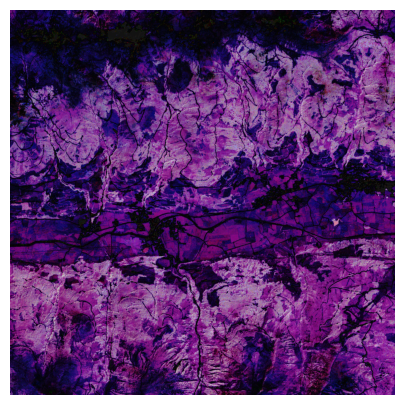

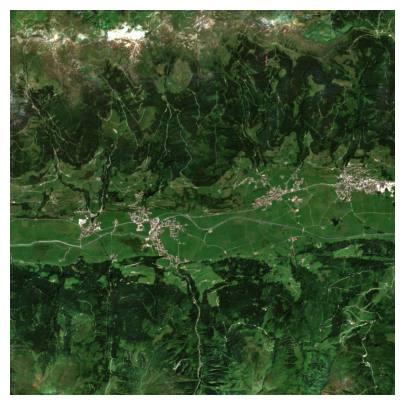

In [ ]:
plot(y_all_predicted[0])
plot(X[0])

Alternative loading and storing of data:
```
# create data sets by combining npy files
path_train_sat = root_path + "train_satellite.npy"
path_train_masks = root_path + "train_masks.npy"

from os import listdir
if not isfile(path_train_sat):
  print("train satellite dataset is generated")
  # image set
  # initialize with the first satellite image
  train_satellite = np.load(path_images + listdir(path_images)[0])
  # concatinate all other images
  for f in listdir(path_images)[1:]:
      current_array = np.load(path_images + f, allow_pickle=True)
      train_satellite = np.concatenate((train_satellite, current_array), axis=0)
  # adjust incorrect shape: (200, 1024, 1024)
  train_satellite = train_satellite.reshape(20, 10, 1024, 1024)
  # save as file
  np.save(path_train_sat, train_satellite, allow_pickle=True, fix_imports=True)
if not isfile(path_train_masks):
  print("train masks dataset is generated")
  # masks
  # initialize with the first mask image
  train_masks = np.load(path_masks + listdir(path_masks)[0])
  # concatinate all other images
  for f in listdir(path_masks)[1:]:
      current_array = np.load(path_masks + f, allow_pickle=True)
      train_masks = np.concatenate((train_masks, current_array), axis=0)
  # save as file
  np.save(root_path + "train_masks.npy", train_masks, allow_pickle=True, fix_imports=True)
  ```

# Handling Large Images: Creating Cutouts
Split the large image into smaller sub-images. Use these for training and prediction.

In [ ]:
!pip install patchify

In [ ]:
from patchify import patchify, unpatchify
cutout_size = 4
color_channels = 10
patch_shape = (color_channels, cutout_size, cutout_size) # needs to have the same number of dimensions as the whole image
step_size = cutout_size # curently exact cropping of images with no overlap

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
first_patches = patchify(X[0], patch_shape, step=step_size)
all_patches = first_patches
for idx in range(1, X.shape[0]):
  img = X[idx]
  patches = patchify(img, patch_shape, step=step_size)
  # add all other patches
  all_patches = np.concatenate((all_patches, patches))

In [ ]:
# check if patch shape is as planned
cutouts = int(X.shape[2]/cutout_size) # only works if the step_size = cutout_size
assert all_patches.shape == (X.shape[0], cutouts, cutouts, color_channels, cutout_size, cutout_size)

check if the original image can be reconstructed:

In [ ]:
all_reconstructed_images = unpatchify(first_patches, X[0].shape)
for idx in range(1, X.shape[0]):
  #select single patch to unpatchify it
  patches = np.expand_dims(all_patches[idx], 0)
  reconstructed_image = unpatchify(patches, X[0].shape)
  all_reconstructed_images = np.concatenate((all_reconstructed_images, reconstructed_image))

all_reconstructed_images = np.reshape(all_reconstructed_images, X.shape)

In [ ]:
# check if unpatchify worked
assert (all_reconstructed_images == X).all()

In [ ]:
del all_reconstructed_images, reconstructed_image

In [ ]:
# put x and y axis patches together
all_patches = np.reshape(all_patches, (all_patches.shape[0], all_patches.shape[1]*all_patches.shape[2], all_patches.shape[3], all_patches.shape[4], all_patches.shape[5]))

In [ ]:
mask_patch_shape = (patch_shape[1], patch_shape[2]) # adjust to mask dimensions

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
all_mask_patches = patchify(y[0], mask_patch_shape, step=step_size)
for idx in range(1, y.shape[0]):
  img = y[idx]
  patches = patchify(img, mask_patch_shape, step=step_size)
  # add all other patches
  all_mask_patches = np.concatenate((all_mask_patches, patches))
del patches

In [ ]:
all_mask_patches = np.reshape(all_mask_patches, (y.shape[0], all_mask_patches.shape[1]**2, all_mask_patches.shape[2], all_mask_patches.shape[3]))

# Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
#Data augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #keras.layers.experimental.preprocessing.RandomRotation(0.4),
    #keras.layers.RandomCrop(224, 224)
])

In [ ]:
image = normalize_color(all_patches[0][0][0][:3])

In [ ]:
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(hspace=0.07, wspace=0.01)
  plt.imshow(augmented_image)
  plt.axis("off")
  #print(augmented_image.shape)
  #print(i)
  #plot_img(augmented_image)

del augmented_image, image

# Dataset Generation

In [ ]:
#conversion to tensors
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((all_patches, all_mask_patches))

In [ ]:
dataset.element_spec